In [1]:
#POOT Library
from ROOT import TMVA, TFile, TTree, TCut, TString
#DNN Library Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Optimizer SWATS 
import swats
#numpy, pandas, matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from importlib import reload
import pandas as pd
import random
from array import array
#ML library
import pickle
import scikitplot as skplt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
#XGBoost Library
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
#Cuda Library
from numba import cuda
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import gc 
from scipy.stats import poisson
import multiprocessing

Welcome to JupyROOT 6.19/01


Cuda Functions for data normalization
1. Calculate sum of a vector

2. Calculate mean value

3. Calculate variance

Function use to do Guassian Normalization:
Mean:
$$\mu_{i}=\frac{\sum x_{i}\times w_{i}}{\sum w_{i}}$$
Variance:
$$\sigma_{i}=\frac{\sum (x_{i}-\mu_{i})^{2}\times w_{i}}{\frac{N-1}{N}\times\sum w_{i}}$$
Normalized input feature:
$$\bar{x_{i}}=\frac{x_{i}-\mu_{i}}{\sigma_{i}}$$

cuda function is in cuda_guass_normal/__iniit__.py
use pip install . or pip install cuda_guass_normal first
package information: https://pypi.org/project/cuda-guass-normal/

In [2]:
import cuda_guass_normal

Load signal and background files:

In [3]:
signalFile = TFile.Open("../sample-train-pDNN-1119/2tag_sr1_sig.root")
backgroundFile = TFile.Open("../sample-train-pDNN-1119/2tag_sr1_bkg.root")

signalTree = signalFile.Get("ntup")
backgroundTree = backgroundFile.Get("ntup")

signalNum = signalTree.GetEntries()
backgroundNum = backgroundTree.GetEntries()
print("signal events number before cut is: ", signalNum)
print("background events number before cut is: ", backgroundNum)

signal events number before cut is:  847545
background events number before cut is:  5159271


Convert minitree into numpy and dataframe:

In [4]:
variable_names=["weight","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]

In [5]:
dim = len(variable_names)-3

In [6]:
print(dim)

22


In [7]:
sig_variable_names=["weight","m_hh_truth","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]

In [8]:
signalArray=signalTree.AsMatrix(sig_variable_names)

backgroundArray=backgroundTree.AsMatrix(variable_names)
    
print(signalArray.shape)
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal_df=pd.DataFrame(data=signalArray,columns=sig_variable_names)
background_df=pd.DataFrame(data=backgroundArray,columns=variable_names)

(847545, 26)
signal yield before cut is:  188883.40753109788
background yield before cut is: 888531.5155499524


In [9]:
signal_df = signal_df[(signal_df["m_hh_truth"]>0)]
signal_df = signal_df.drop(columns=["m_hh_truth"])

In [10]:
signal_df.describe()

weight          is_ee          is_mm     bjet_0_pt  \
count  5.305610e+05  530561.000000  530561.000000  5.305610e+05   
mean   3.559795e-01       0.256530       0.379053  1.512128e+05   
std    5.147180e-01       0.436718       0.485152  9.199053e+04   
min    6.319729e-10       0.000000       0.000000  2.020224e+04   
25%    1.888462e-02       0.000000       0.000000  8.158923e+04   
50%    1.904433e-01       0.000000       0.000000  1.294589e+05   
75%    3.568761e-01       1.000000       1.000000  1.952010e+05   
max    4.462970e+00       1.000000       1.000000  1.004812e+06   

          bjet_0_eta      bjet_1_pt     bjet_1_eta           ll_m  \
count  530561.000000  530561.000000  530561.000000  530561.000000   
mean       -0.003452   63766.023134      -0.003199   38707.906082   
std         1.060315   40508.265960       1.125231   15368.665272   
min        -2.499946   20000.126953      -2.499987   15000.055664   
25%        -0.775502   34773.378906      -0.837694   26271.755859   
50%        -0.004029   51597.636719      -0.004188   36025.082031   
75%         0.767917   80449.921875       0.830619   49490.496094   
max         2.499710  622801.812500       2.499955  109979.226562   

               ll_pt      ll_deltar  ...    bb_deltaeta     bb_deltapt  \
count  530561.000000  530561.000000  ...  530561.000000  530561.000000   
mean   111362.588680       1.004039  ...      -0.000254   87446.746095   
std     73243.158930       0.673747  ...       0.947487   84730.601338   
min       187.340652       0.056613  ...      -4.950650       0.066406   
25%     57010.644531       0.512782  ...      -0.627143   24700.296875   
50%     93714.617188       0.805770  ...      -0.000047   61392.003906   
75%    146830.531250       1.290662  ...       0.625933  123447.398438   
max    827778.062500       4.151072  ...       4.968467  867394.937500   

             met_met        met_sig        met_phi   mt_lep0_met  \
count  530561.000000  530561.000000  530561.000000  5.305610e+05   
mean   107703.648481       5.639034      -0.001377  5.522565e+04   
std     84028.909560       3.464216       1.810262  3.933389e+04   
min        76.122032       0.005580      -3.141581  6.503637e-02   
25%     46585.410156       2.989647      -1.567976  2.461884e+04   
50%     82673.875000       4.941213      -0.001659  5.045537e+04   
75%    144849.515625       7.659049       1.562060  7.888500e+04   
max    824746.562500      25.785284       3.141591  1.247306e+06   

         mt_lep1_met        m_bbll     m_bbllmet          m_hh  
count  530561.000000  5.305610e+05  5.305610e+05  5.305610e+05  
mean    41562.499517  3.689475e+05  5.207107e+05  5.223261e+05  
std     27912.204951  1.759012e+05  2.420657e+05  4.512495e+05  
min         0.414121  6.144497e+04  8.850238e+04  0.000000e+00  
25%     19830.376953  2.386102e+05  3.424726e+05  0.000000e+00  
50%     38401.628906  3.367225e+05  4.705784e+05  5.068599e+05  
75%     58679.765625  4.500594e+05  6.548527e+05  8.025010e+05  
max    484985.187500  4.658529e+06  4.833936e+06  4.058340e+06  

[8 rows x 25 columns]

In [11]:
background_df.describe()

weight         is_ee         is_mm     bjet_0_pt    bjet_0_eta  \
count  5.159271e+06  5.159271e+06  5.159271e+06  5.159271e+06  5.159271e+06   
mean   1.722204e-01  1.822263e-01  2.817512e-01  1.010699e+05  9.771552e-05   
std    3.276774e-01  3.860310e-01  4.498528e-01  6.725275e+04  1.108487e+00   
min   -7.696216e+01  0.000000e+00  0.000000e+00  2.002584e+04 -2.499996e+00   
25%    2.601310e-03  0.000000e+00  0.000000e+00  6.206445e+04 -8.156625e-01   
50%    1.558288e-01  0.000000e+00  0.000000e+00  8.610972e+04  7.724593e-04   
75%    3.369956e-01  0.000000e+00  1.000000e+00  1.202934e+05  8.149481e-01   
max    8.287585e+01  1.000000e+00  1.000000e+00  2.654668e+06  2.499994e+00   

          bjet_1_pt    bjet_1_eta          ll_m         ll_pt     ll_deltar  \
count  5.159271e+06  5.159271e+06  5.159271e+06  5.159271e+06  5.159271e+06   
mean   5.395401e+04  1.333529e-03  5.793640e+04  6.976497e+04  1.772611e+00   
std    3.605832e+04  1.191836e+00  2.237222e+04  4.285024e+04  7.791878e-01   
min    2.000001e+04 -2.499998e+00  1.500004e+04  1.366817e+01  3.770936e-02   
25%    3.121203e+04 -9.048420e-01  4.138744e+04  4.216277e+04  1.152790e+00   
50%    4.515648e+04  1.974232e-03  5.733622e+04  6.232197e+04  1.709661e+00   
75%    6.541844e+04  9.069359e-01  7.203803e+04  8.794131e+04  2.362475e+00   
max    1.685634e+06  2.499992e+00  1.099999e+05  1.751289e+06  4.787987e+00   

       ...   bb_deltaeta    bb_deltapt       met_met       met_sig  \
count  ...  5.159271e+06  5.159271e+06  5.159271e+06  5.159271e+06   
mean   ... -1.235813e-03  4.711584e+04  7.636854e+04  4.693107e+00   
std    ...  1.388656e+00  5.508476e+04  5.276260e+04  2.769484e+00   
min    ... -4.981182e+00  0.000000e+00  2.330228e+01  1.632308e-03   
25%    ... -9.320501e-01  1.444171e+04  3.927316e+04  2.523403e+00   
50%    ... -6.287396e-04  3.260977e+04  6.708141e+04  4.318405e+00   
75%    ...  9.304487e-01  6.138637e+04  1.010050e+05  6.440901e+00   
max    ...  4.995625e+00  2.376301e+06  2.357084e+06  4.081993e+01   

            met_phi   mt_lep0_met   mt_lep1_met        m_bbll     m_bbllmet  \
count  5.159271e+06  5.159271e+06  5.159271e+06  5.159271e+06  5.159271e+06   
mean  -1.179402e-02  8.527097e+04  5.524821e+04  2.883332e+05  3.910617e+05   
std    1.812925e+00  5.442718e+04  3.312205e+04  1.467292e+05  1.652968e+05   
min   -3.141592e+00  1.665384e-02  5.768246e-03  4.398616e+04  5.769907e+04   
25%   -1.581467e+00  4.459618e+04  2.919193e+04  2.074354e+05  2.962211e+05   
50%   -2.397689e-02  8.015865e+04  5.352642e+04  2.571518e+05  3.604599e+05   
75%    1.559135e+00  1.167751e+05  7.770893e+04  3.269880e+05  4.440441e+05   
max    3.141591e+00  1.908282e+06  1.206576e+06  7.115014e+06  7.230100e+06   

               m_hh  
count  5.159271e+06  
mean   2.320993e+05  
std    2.465001e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    2.772872e+05  
75%    3.738259e+05  
max    8.043632e+06  

[8 rows x 25 columns]

select events in HM/DF (region4) region $$m_{ll}<75$$ GeV and different flavor lepton pair:

In [12]:
signal_df_region3=signal_df[(signal_df["ll_m"]<75000.0)&((signal_df["is_ee"]==1)|(signal_df["is_mm"]==1))]
background_df_region3=background_df[(background_df["ll_m"]<75000.0)&((background_df["is_ee"]==1)|(background_df["is_mm"]==1))]
SigYield=signal_df_region3["weight"].sum()
BkgYield=background_df_region3["weight"].sum()
SBratio=SigYield/BkgYield
print("signal yield in region 3 is: ",SigYield)
print("background yield in region 3 is: ",BkgYield)
print("S/B ratio is: ",SBratio)

signal yield in region 3 is:  94247.13348251817
background yield in region 3 is:  373556.81803766906
S/B ratio is:  0.2522966492155268


Pre-cut before feed to DNN:
$$80<m_{bb}<150 GeV$$ $$\Delta R(bb)<2.8$$

In [13]:
plt.hist(signal_df_region3["m_hh"].values,bins=20,weights=signal_df_region3["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

Text(0.5, 0, 'Pytorch Score')

Text(0.5, 0, 'Pytorch Score')

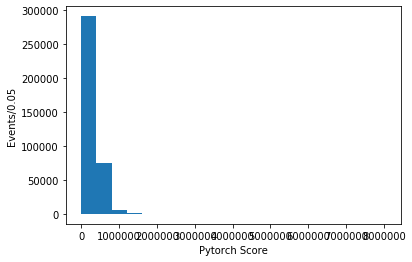

In [14]:
plt.hist(background_df_region3["m_hh"].values,bins=20,weights=background_df_region3["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


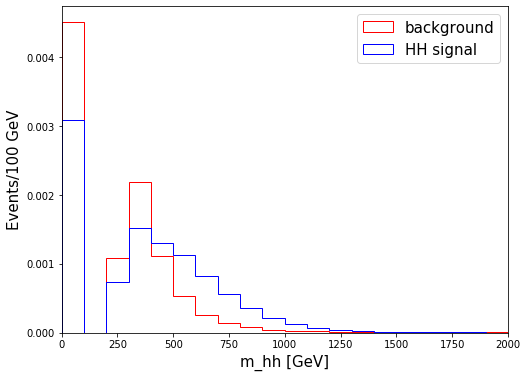

In [15]:
plt.figure(figsize=(8,6))
plt.xlim(0,2000)
plt.hist(background_df_region3["m_hh"].values/1000,bins=20,range=[0, 2000],weights=background_df_region3["weight"].values,fill=False, color='red',normed=1,histtype='step',label="background")
plt.hist(signal_df_region3["m_hh"].values/1000,bins=20,range=[0, 2000],weights=signal_df_region3["weight"].values,fill=False, color='blue',normed=1,histtype='step',label="HH signal")
plt.legend(loc = 'upper right',prop={'size': 15})
plt.ylabel('Events/100 GeV',fontsize=15)
plt.xlabel('m_hh [GeV]',fontsize=15)
figure_fig = plt.gcf()
figure_fig.savefig('../figures/1120/m_hh_region3.pdf', format='pdf', dpi=500)

In [16]:
def sample_value(leng, target_df, weight_df, variable_name, weight_name):
    target_np = target_df[variable_name].values
    weight_np = weight_df[weight_name].values
    sum_weight = sum(weight_np)
    weight_np = weight_np/sum_weight
    result_np = []
    #for num in source_np:
        #source_np[i] = np.random.choice(target_np, p = weight_np, replace=True)
        #i=i+1
        #print(i)
    result_np = np.random.choice(target_np, p = weight_np, replace=True,size=leng)
    return(result_np)
    

In [17]:
result_np = sample_value(len(background_df_region3["m_hh"].values), signal_df_region3, signal_df_region3,
                         "m_hh","weight")
                         

In [18]:
print(result_np.reshape(-1,1))

[[     0.    ]
 [559283.5625]
 [659609.4375]
 ...
 [     0.    ]
 [     0.    ]
 [414070.    ]]


In [19]:
print(len(result_np.reshape(-1,1)))

2393786


In [20]:
plt.figure(figsize=(8,6))
plt.hist(result_np/1000,bins=20,range=[0,2000],weights=background_df_region3["weight"].values,fill=False, color='red',normed=1,histtype='step',label="sampled background")
plt.hist(signal_df_region3["m_hh"].values/1000,bins=20,range=[0,2000],weights=signal_df_region3["weight"].values,fill=False, color='blue',normed=1,histtype='step',label="HH signal")
plt.legend(loc = 'upper right',prop={'size': 15})
plt.xlim(0,2000)
plt.ylabel('Events/100 GeV',fontsize=15)
plt.xlabel('m_hh [GeV]',fontsize=15)
figure_fig = plt.gcf()
figure_fig.savefig('../figures/1120/sampled_m_hh_region3.pdf', format='pdf', dpi=500)

/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
background_df_region3_np = background_df_region3.values


In [22]:
background_df_region3_np[:,24]=result_np

In [23]:
background_df_region3 = pd.DataFrame(data=background_df_region3_np, columns=variable_names)

Text(0.5, 0, 'Pytorch Score')

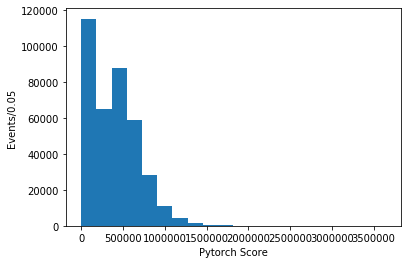

In [24]:
plt.hist(background_df_region3["m_hh"].values,bins=20,weights=background_df_region3["weight"].values)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')

In [25]:
background_df_region3.describe()

weight         is_ee         is_mm     bjet_0_pt    bjet_0_eta  \
count  2.393786e+06  2.393786e+06  2.393786e+06  2.393786e+06  2.393786e+06   
mean   1.560527e-01  3.927481e-01  6.072519e-01  1.010205e+05  1.400683e-04   
std    4.270553e-01  4.883617e-01  4.883617e-01  7.358511e+04  1.131283e+00   
min   -7.696216e+01  0.000000e+00  0.000000e+00  2.002584e+04 -2.499996e+00   
25%    3.658609e-03  0.000000e+00  0.000000e+00  5.999736e+04 -8.391612e-01   
50%    1.179571e-01  0.000000e+00  1.000000e+00  8.439955e+04  6.456219e-04   
75%    3.118094e-01  1.000000e+00  1.000000e+00  1.192357e+05  8.391817e-01   
max    8.287585e+01  1.000000e+00  1.000000e+00  2.654668e+06  2.499994e+00   

          bjet_1_pt    bjet_1_eta          ll_m         ll_pt     ll_deltar  \
count  2.393786e+06  2.393786e+06  2.393786e+06  2.393786e+06  2.393786e+06   
mean   5.278258e+04  9.303658e-04  5.035372e+04  7.127235e+04  1.634203e+00   
std    3.884284e+04  1.214131e+00  1.632708e+04  4.670892e+04  7.577590e-01   
min    2.000002e+04 -2.499993e+00  1.500004e+04  1.366817e+01  3.770936e-02   
25%    2.971690e+04 -9.311986e-01  3.828628e+04  4.232964e+04  1.033808e+00   
50%    4.322491e+04  1.816393e-03  5.208140e+04  6.245697e+04  1.537632e+00   
75%    6.343097e+04  9.331193e-01  6.440899e+04  8.870972e+04  2.177090e+00   
max    1.684385e+06  2.499983e+00  7.499999e+04  1.751289e+06  4.237228e+00   

       ...   bb_deltaeta    bb_deltapt       met_met       met_sig  \
count  ...  2.393786e+06  2.393786e+06  2.393786e+06  2.393786e+06   
mean   ... -7.902974e-04  4.823789e+04  6.950205e+04  4.272350e+00   
std    ...  1.431414e+00  5.992461e+04  5.193173e+04  2.773347e+00   
min    ... -4.981182e+00  3.125000e-02  4.026418e+01  2.346999e-03   
25%    ... -9.493272e-01  1.408249e+04  3.191435e+04  2.048248e+00   
50%    ... -4.925365e-04  3.231734e+04  5.885136e+04  3.759029e+00   
75%    ...  9.491643e-01  6.169602e+04  9.429949e+04  6.023935e+00   
max    ...  4.995625e+00  2.376301e+06  2.357084e+06  4.081993e+01   

            met_phi   mt_lep0_met   mt_lep1_met        m_bbll     m_bbllmet  \
count  2.393786e+06  2.393786e+06  2.393786e+06  2.393786e+06  2.393786e+06   
mean  -1.416104e-02  7.990390e+04  5.159344e+04  2.907001e+05  3.849301e+05   
std    1.812722e+00  5.218967e+04  3.230793e+04  1.698154e+05  1.834628e+05   
min   -3.141592e+00  1.665384e-02  5.768246e-03  4.621849e+04  5.769907e+04   
25%   -1.582944e+00  4.054872e+04  2.595458e+04  2.011067e+05  2.835182e+05   
50%   -2.808662e-02  7.421083e+04  4.875556e+04  2.522981e+05  3.501038e+05   
75%    1.556807e+00  1.104750e+05  7.352851e+04  3.271154e+05  4.367206e+05   
max    3.141591e+00  1.908282e+06  1.206576e+06  7.115014e+06  7.230100e+06   

               m_hh  
count  2.393786e+06  
mean   3.731946e+05  
std    3.127060e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    3.756389e+05  
75%    5.750409e+05  
max    3.642338e+06  

[8 rows x 25 columns]

In [26]:
signal_df_region3.describe()

weight          is_ee          is_mm     bjet_0_pt  \
count  3.372160e+05  337216.000000  337216.000000  3.372160e+05   
mean   2.794859e-01       0.403614       0.596386  1.554093e+05   
std    4.739951e-01       0.490622       0.490622  9.451752e+04   
min    6.319729e-10       0.000000       0.000000  2.020224e+04   
25%    1.202416e-02       0.000000       0.000000  8.310843e+04   
50%    4.596166e-02       0.000000       1.000000  1.327837e+05   
75%    2.600730e-01       1.000000       1.000000  2.029490e+05   
max    4.317383e+00       1.000000       1.000000  1.004812e+06   

          bjet_0_eta      bjet_1_pt     bjet_1_eta           ll_m  \
count  337216.000000  337216.000000  337216.000000  337216.000000   
mean       -0.005025   64997.536861      -0.003759   38661.133334   
std         1.056846   41616.853818       1.122224   15673.124989   
min        -2.499946   20000.126953      -2.499987   15000.055664   
25%        -0.773151   35044.745117      -0.834762   25976.398438   
50%        -0.005993   52333.644531      -0.003815   35303.173828   
75%         0.762445   82403.425781       0.827726   49979.896484   
max         2.499710  622801.812500       2.499914   74999.492188   

               ll_pt      ll_deltar  ...    bb_deltaeta     bb_deltapt  \
count  337216.000000  337216.000000  ...  337216.000000  337216.000000   
mean   109228.621732       1.016448  ...      -0.001266   90411.757918   
std     72770.406446       0.680807  ...       0.939422   87201.218314   
min       202.893936       0.056613  ...      -4.860208       0.359375   
25%     56033.906250       0.522615  ...      -0.618973   25441.217285   
50%     91077.054688       0.816148  ...       0.001402   63460.001953   
75%    143248.074219       1.301335  ...       0.615766  127993.625000   
max    827778.062500       4.151072  ...       4.968467  867394.937500   

             met_met        met_sig        met_phi   mt_lep0_met  \
count  337216.000000  337216.000000  337216.000000  3.372160e+05   
mean   114142.895019       5.879347      -0.001285  5.178166e+04   
std     88150.671244       3.588732       1.809644  3.897366e+04   
min        76.122032       0.005580      -3.141567  6.503637e-02   
25%     48502.417969       3.097521      -1.566284  2.164787e+04   
50%     88322.320312       5.177246      -0.000614  4.549544e+04   
75%    155692.578125       8.046586       1.560436  7.464068e+04   
max    765864.187500      25.090527       3.141591  1.247306e+06   

         mt_lep1_met        m_bbll     m_bbllmet          m_hh  
count  337216.000000  3.372160e+05  3.372160e+05  3.372160e+05  
mean    39994.954591  3.704964e+05  5.314965e+05  5.372134e+05  
std     27578.323100  1.760366e+05  2.483003e+05  4.562437e+05  
min         0.414121  6.144497e+04  8.850238e+04  0.000000e+00  
25%     18603.300293  2.391437e+05  3.452127e+05  0.000000e+00  
50%     36471.943359  3.370805e+05  4.784005e+05  5.174611e+05  
75%     56400.016602  4.561006e+05  6.878620e+05  8.210666e+05  
max    484985.187500  4.079301e+06  4.160124e+06  4.058340e+06  

[8 rows x 25 columns]

In [27]:
signal_df_cut=signal_df_region3#[(signal_df_region4["bb_m"]>80000.0)&(signal_df_region4["bb_m"]<150000.0)&(signal_df_region4["bb_deltar"]<2.8)]
background_df_cut=background_df_region3#[(background_df_region4["bb_m"]>80000.0)&(background_df_region4["bb_m"]<150000.0)&(background_df_region4["bb_deltar"]<2.8)]
SigYield1=signal_df_cut["weight"].sum()
BkgYield1=background_df_cut["weight"].sum()
SBratio=SigYield1/BkgYield1
print("signal yield in region 3 after precut is: ",SigYield1)
print("background yield in region 3 after precut is: ",BkgYield1)
print("S/B ratio is: ",SBratio)

signal yield in region 3 after precut is:  94247.13348251817
background yield in region 3 after precut is:  373556.81803766906
S/B ratio is:  0.2522966492155268


In Guassian normalization, mean and variance are calculated using total signal+background event in HM/DF region:

In [28]:
dataNormal_pre=signal_df_cut.append(background_df_cut)
dataNormal_weight_df=dataNormal_pre["weight"]
dataNormal_df=dataNormal_pre.drop(columns=["weight","is_ee","is_mm"])
dataNormal_df.describe()

dataNormal=dataNormal_df.values
dataNormal_weight=dataNormal_weight_df.values

Add label to signal and background:

In [29]:
signal_df_cut["label"]=1
background_df_cut["label"]=0

signal_df_cut.describe()

/home/shuzhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


weight          is_ee          is_mm     bjet_0_pt  \
count  3.372160e+05  337216.000000  337216.000000  3.372160e+05   
mean   2.794859e-01       0.403614       0.596386  1.554093e+05   
std    4.739951e-01       0.490622       0.490622  9.451752e+04   
min    6.319729e-10       0.000000       0.000000  2.020224e+04   
25%    1.202416e-02       0.000000       0.000000  8.310843e+04   
50%    4.596166e-02       0.000000       1.000000  1.327837e+05   
75%    2.600730e-01       1.000000       1.000000  2.029490e+05   
max    4.317383e+00       1.000000       1.000000  1.004812e+06   

          bjet_0_eta      bjet_1_pt     bjet_1_eta           ll_m  \
count  337216.000000  337216.000000  337216.000000  337216.000000   
mean       -0.005025   64997.536861      -0.003759   38661.133334   
std         1.056846   41616.853818       1.122224   15673.124989   
min        -2.499946   20000.126953      -2.499987   15000.055664   
25%        -0.773151   35044.745117      -0.834762   25976.398438   
50%        -0.005993   52333.644531      -0.003815   35303.173828   
75%         0.762445   82403.425781       0.827726   49979.896484   
max         2.499710  622801.812500       2.499914   74999.492188   

               ll_pt      ll_deltar  ...     bb_deltapt        met_met  \
count  337216.000000  337216.000000  ...  337216.000000  337216.000000   
mean   109228.621732       1.016448  ...   90411.757918  114142.895019   
std     72770.406446       0.680807  ...   87201.218314   88150.671244   
min       202.893936       0.056613  ...       0.359375      76.122032   
25%     56033.906250       0.522615  ...   25441.217285   48502.417969   
50%     91077.054688       0.816148  ...   63460.001953   88322.320312   
75%    143248.074219       1.301335  ...  127993.625000  155692.578125   
max    827778.062500       4.151072  ...  867394.937500  765864.187500   

             met_sig        met_phi   mt_lep0_met    mt_lep1_met  \
count  337216.000000  337216.000000  3.372160e+05  337216.000000   
mean        5.879347      -0.001285  5.178166e+04   39994.954591   
std         3.588732       1.809644  3.897366e+04   27578.323100   
min         0.005580      -3.141567  6.503637e-02       0.414121   
25%         3.097521      -1.566284  2.164787e+04   18603.300293   
50%         5.177246      -0.000614  4.549544e+04   36471.943359   
75%         8.046586       1.560436  7.464068e+04   56400.016602   
max        25.090527       3.141591  1.247306e+06  484985.187500   

             m_bbll     m_bbllmet          m_hh     label  
count  3.372160e+05  3.372160e+05  3.372160e+05  337216.0  
mean   3.704964e+05  5.314965e+05  5.372134e+05       1.0  
std    1.760366e+05  2.483003e+05  4.562437e+05       0.0  
min    6.144497e+04  8.850238e+04  0.000000e+00       1.0  
25%    2.391437e+05  3.452127e+05  0.000000e+00       1.0  
50%    3.370805e+05  4.784005e+05  5.174611e+05       1.0  
75%    4.561006e+05  6.878620e+05  8.210666e+05       1.0  
max    4.079301e+06  4.160124e+06  4.058340e+06       1.0  

[8 rows x 26 columns]

Split training and testing sub-sample. Test size=0.2

In [30]:
signal_df_train1,signal_df_test1=train_test_split(signal_df_cut,test_size=0.2)
background_df_train1,background_df_test1=train_test_split(background_df_cut,test_size=0.2)

Drop negative weight events in training and testing. Negative events will cause DNN trainning stop too early and loss oscillation in late epoches.

In [31]:
signal_df_train=signal_df_train1[signal_df_train1["weight"]>0]
signal_df_test=signal_df_test1[signal_df_test1["weight"]>0]
background_df_train=background_df_train1[background_df_train1["weight"]>0]
background_df_test=background_df_test1[background_df_test1["weight"]>0]

signal_df_train.describe()

weight          is_ee          is_mm      bjet_0_pt  \
count  2.697720e+05  269772.000000  269772.000000  269772.000000   
mean   2.791239e-01       0.404145       0.595855  155408.164820   
std    4.732588e-01       0.490727       0.490727   94504.045714   
min    6.319729e-10       0.000000       0.000000   20366.541016   
25%    1.201857e-02       0.000000       0.000000   83054.402344   
50%    4.597900e-02       0.000000       1.000000  132781.554688   
75%    2.601512e-01       1.000000       1.000000  202911.730469   
max    4.317383e+00       1.000000       1.000000  951115.000000   

          bjet_0_eta      bjet_1_pt     bjet_1_eta           ll_m  \
count  269772.000000  269772.000000  269772.000000  269772.000000   
mean       -0.004901   64993.276278      -0.002197   38651.429178   
std         1.057031   41586.807689       1.121757   15667.743874   
min        -2.499876   20000.126953      -2.499987   15000.069336   
25%        -0.774627   35049.150391      -0.833937   25966.266602   
50%        -0.004396   52375.513672      -0.001319   35270.068359   
75%         0.763128   82400.142578       0.830181   49964.636719   
max         2.499710  622801.812500       2.499914   74998.718750   

               ll_pt      ll_deltar  ...     bb_deltapt        met_met  \
count  269772.000000  269772.000000  ...  269772.000000  269772.000000   
mean   109152.991198       1.016507  ...   90414.888535  114171.571753   
std     72663.482250       0.680927  ...   87173.240162   88184.679763   
min       263.579193       0.056613  ...       0.359375      76.122032   
25%     56019.313477       0.522610  ...   25418.340820   48535.346680   
50%     91163.566406       0.815577  ...   63383.812500   88279.714844   
75%    143204.773438       1.301731  ...  128059.417969  155789.777344   
max    827778.062500       4.151072  ...  867394.937500  765864.187500   

             met_sig        met_phi   mt_lep0_met    mt_lep1_met  \
count  269772.000000  269772.000000  2.697720e+05  269772.000000   
mean        5.880954      -0.003173  5.173659e+04   40008.094805   
std         3.590755       1.809478  3.891258e+04   27575.546273   
min         0.005580      -3.141567  6.503637e-02       0.414121   
25%         3.100557      -1.569350  2.165264e+04   18629.883789   
50%         5.175823      -0.002362  4.547647e+04   36491.765625   
75%         8.053474       1.557627  7.458008e+04   56429.428711   
max        23.911308       3.141591  1.247306e+06  457076.593750   

             m_bbll     m_bbllmet          m_hh     label  
count  2.697720e+05  2.697720e+05  2.697720e+05  269772.0  
mean   3.704999e+05  5.315011e+05  5.370706e+05       1.0  
std    1.762977e+05  2.485530e+05  4.561120e+05       0.0  
min    6.144497e+04  8.850238e+04  0.000000e+00       1.0  
25%    2.391431e+05  3.450942e+05  0.000000e+00       1.0  
50%    3.370800e+05  4.784229e+05  5.176921e+05       1.0  
75%    4.559069e+05  6.877055e+05  8.202876e+05       1.0  
max    4.079301e+06  4.160124e+06  4.058340e+06       1.0  

[8 rows x 26 columns]

Scale total weight of signal= total weight of background

In [32]:
background_importance = 5.0 # set importance of background
train_ratio=signal_df_train["weight"].sum()/background_df_train["weight"].sum()*background_importance
test_ratio=signal_df_test["weight"].sum()/background_df_test["weight"].sum()*background_importance
signal_df_train["weight"]=signal_df_train["weight"]/train_ratio
signal_df_test["weight"]=signal_df_test["weight"]/test_ratio

Create trainning and testing dataset:

In [33]:
data_df_train=signal_df_train.append(background_df_train)
data_df_test=signal_df_test.append(background_df_test)

data_df_train=shuffle(data_df_train)
data_df_test=shuffle(data_df_test)

data_train_label=data_df_train["label"]
data_train_weight=data_df_train["weight"]
data_train_data=data_df_train.drop(columns=["weight","label","is_mm","is_ee"])
data_test_label=data_df_test["label"]
data_test_weight=data_df_test["weight"]
data_test_data=data_df_test.drop(columns=["weight","label","is_mm","is_ee"])

In [34]:
data_train_data.describe()

bjet_0_pt    bjet_0_eta     bjet_1_pt    bjet_1_eta          ll_m  \
count  2.094643e+06  2.094643e+06  2.094643e+06  2.094643e+06  2.094643e+06   
mean   1.085014e+05 -4.102763e-04  5.471267e+04  3.284968e-04  4.873634e+04   
std    7.893930e+04  1.117902e+00  3.950774e+04  1.198322e+00  1.667827e+04   
min    2.002584e+04 -2.499996e+00  2.000002e+04 -2.499987e+00  1.500005e+04   
25%    6.226132e+04 -8.261948e-01  3.062417e+04 -9.123244e-01  3.540777e+04   
50%    8.836323e+04  7.241595e-04  4.466847e+04  1.238930e-03  5.001165e+04   
75%    1.283376e+05  8.241560e-01  6.585583e+04  9.137472e-01  6.316026e+04   
max    2.654668e+06  2.499994e+00  1.684385e+06  2.499983e+00  7.499999e+04   

              ll_pt     ll_deltar   ll_deltaeta   ll_deltaphi          bb_m  \
count  2.094643e+06  2.094643e+06  2.094643e+06  2.094643e+06  2.094643e+06   
mean   7.617880e+04  1.549661e+00  1.052189e-04 -1.041409e-03  1.499210e+05   
std    5.222400e+04  7.737871e-01  8.803960e-01  1.491676e+00  1.270623e+05   
min    1.366817e+01  3.770936e-02 -3.213325e+00 -3.141586e+00  1.039779e+04   
25%    4.380670e+04  9.304188e-01 -6.108687e-01 -1.077093e+00  8.406760e+04   
50%    6.487764e+04  1.442143e+00 -5.574226e-04 -2.237320e-03  1.208332e+05   
75%    9.388216e+04  2.093198e+00  6.118526e-01  1.076418e+00  1.787109e+05   
max    1.707682e+06  4.227499e+00  3.211168e+00  3.141593e+00  6.025520e+06   

       ...   bb_deltaeta    bb_deltapt       met_met       met_sig  \
count  ...  2.094643e+06  2.094643e+06  2.094643e+06  2.094643e+06   
mean   ... -7.387730e-04  5.378870e+04  7.618447e+04  4.537466e+00   
std    ...  1.366734e+00  6.586480e+04  5.955025e+04  2.933248e+00   
min    ... -4.981182e+00  3.125000e-02  4.497328e+01  2.704702e-03   
25%    ... -8.840268e-01  1.506969e+04  3.474723e+04  2.217756e+00   
50%    ...  4.064441e-04  3.474517e+04  6.295868e+04  4.013085e+00   
75%    ...  8.829993e-01  6.789484e+04  1.005969e+05  6.323407e+00   
max    ...  4.968467e+00  2.376301e+06  2.357084e+06  3.985905e+01   

            met_phi   mt_lep0_met   mt_lep1_met        m_bbll     m_bbllmet  \
count  2.094643e+06  2.094643e+06  2.094643e+06  2.094643e+06  2.094643e+06   
mean  -1.180249e-02  7.701504e+04  5.060665e+04  3.008290e+05  4.049483e+05   
std    1.812279e+00  5.163382e+04  3.201162e+04  1.729913e+05  1.991147e+05   
min   -3.141592e+00  6.503637e-02  5.768246e-03  4.621849e+04  6.180106e+04   
25%   -1.580557e+00  3.770850e+04  2.525224e+04  2.039148e+05  2.886629e+05   
50%   -2.361751e-02  7.100809e+04  4.761588e+04  2.588571e+05  3.604846e+05   
75%    1.558144e+00  1.070684e+05  7.213457e+04  3.428615e+05  4.598737e+05   
max    3.141591e+00  1.908282e+06  1.206576e+06  6.451676e+06  6.480334e+06   

               m_hh  
count  2.094643e+06  
mean   3.942757e+05  
std    3.391048e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    3.863422e+05  
75%    6.001976e+05  
max    4.058340e+06  

[8 rows x 22 columns]

Convert dataframe into numpy array:

In [35]:
dataTrainSample=data_train_data.values
dataTestSample=data_test_data.values
dataTrainWeight=data_train_weight.values
dataTestWeight=data_test_weight.values
dataTrainLabel=data_train_label.values
dataTestLabel=data_test_label.values

Prepare signal and background array for performance checking:

In [36]:
signal_df_weight=signal_df_cut["weight"]
signal_df_data=signal_df_cut.drop(columns=["weight","label","is_mm","is_ee"])
background_df_weight=background_df_cut["weight"]
background_df_data=background_df_cut.drop(columns=["weight","label","is_mm","is_ee"])
signalSample=signal_df_data.values
backgroundSample=background_df_data.values
signalWeight=signal_df_weight.values
backgroundWeight=background_df_weight.values

Normalize input featrues:

In [37]:
reload(cuda_guass_normal)

dataTrainSample1=cuda_guass_normal.guass_normal(dataTrainSample,dataNormal,dataNormal_weight)
dataTestSample1=cuda_guass_normal.guass_normal(dataTestSample,dataNormal,dataNormal_weight)

signalSample1=cuda_guass_normal.guass_normal(signalSample,dataNormal,dataNormal_weight)
backgroundSample1=cuda_guass_normal.guass_normal(backgroundSample,dataNormal,dataNormal_weight)

In [38]:
plt.hist(dataTrainSample1[:,10])

(array([2.005232e+06, 8.461900e+04, 4.068000e+03, 5.760000e+02,
        1.230000e+02, 1.800000e+01, 4.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([-1.53237444,  3.59538843,  8.72315129, 13.85091416, 18.97867702,
        24.10643989, 29.23420275, 34.36196561, 39.48972848, 44.61749134,
        49.74525421]),
 <a list of 10 Patch objects>)

In [39]:
plt.hist(dataTrainWeight)

(array([2.094178e+06, 3.500000e+02, 3.700000e+01, 4.400000e+01,
        3.000000e+01, 1.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([3.49842539e-10, 8.28758497e+00, 1.65751699e+01, 2.48627549e+01,
        3.31503399e+01, 4.14379249e+01, 4.97255098e+01, 5.80130948e+01,
        6.63006798e+01, 7.45882647e+01, 8.28758497e+01]),
 <a list of 10 Patch objects>)

Create dataLoader for trainning and load to GPU. If no GPU avaliable, use "torch.device("cpu")
Batch size in trainning: 5000. Use large batch size due to signal and background event num is highly unbalanced.

In [40]:
num_cpu=multiprocessing.cpu_count()
print(num_cpu)

16


In [41]:
drv.init()
device = torch.device("cuda:0")
y_tensor = torch.tensor(dataTrainLabel, dtype=torch.float)#.to(device)
WeightTensor=torch.tensor((dataTrainWeight), dtype=torch.float)#.to(device)
dataTrainTensor=torch.tensor(dataTrainSample1, dtype=torch.float)#.to(device)
dataTestTensor=torch.tensor(dataTestSample1,dtype=torch.float)#.to(device)
TrainDataset = TensorDataset( WeightTensor, dataTrainTensor, y_tensor)
TrainLoader = DataLoader(TrainDataset, batch_size=15000, shuffle=False,num_workers=num_cpu-10,pin_memory=True)
TestWeightTensor=torch.tensor(dataTestWeight,dtype=torch.float)#.to(device)
test_y_tensor=torch.tensor(dataTestLabel, dtype=torch.float)#.to(device)
TestDataset = TensorDataset((TestWeightTensor), dataTestTensor, test_y_tensor)
TestLoader = DataLoader(TestDataset, batch_size=30000, shuffle=False,num_workers=num_cpu-10,pin_memory=True)

Build model: 21 input variables, 3 hidden layer, 100 nodes per layer, 1 dropout=0.2

Mish: a new Non-Monotonic Neural Activation Function. Better performance and stablity than ReLU. Refernce: https://arxiv.org/pdf/1908.08681.pdf

In [42]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x *( torch.tanh(F.softplus(x)))

In [43]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.utils.weight_norm(nn.Linear(22, 100),name='weight')
        self.relu1 = Mish()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu2 = Mish()
        self.fc3 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu3 = Mish()
        self.fc4 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu4 = Mish()
        self.out = nn.utils.weight_norm(nn.Linear(100, 1),name='weight')
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.fc2(h2)
        h3 = self.relu3(a3)
        a4 = self.fc2(h3)
        h4 = self.relu4(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

In [44]:
class ResNet(nn.Module):
    
    def __init__(self,dim):
        super().__init__()
        self.fc1 = nn.utils.weight_norm(nn.Linear(dim, 100),name='weight')
        self.relu1 = Mish()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu2 = Mish()
        self.fc3 = nn.utils.weight_norm(nn.Linear(100, 100),name='weight')
        self.relu3 = Mish()
        self.out = nn.utils.weight_norm(nn.Linear(100, dim),name='weight')
        self.out_act = Mish()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        #dout = self.dout(h1)
        a2 = self.fc2(h1)
        h2 = self.relu2(a2)
        a3 = self.fc3(h2)
        h3 = self.relu3(a3)
        a4 = self.out(h3)
        y = self.out_act(a4+input_)
        return y

Init weights in each layer use xavier normal:

In [45]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

trainning part:

In [46]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, data, target) in enumerate(train_loader):
        batch_n=batch_n+1
        data, target,sample_weight = data.to(device), target.to(device), sample_weight.to(device)
        
        optimizer.zero_grad()
        data=data.squeeze()
        output = model(data)
        loss_function.weight = sample_weight/sample_weight.mean()
        #my_weight=sample_weight/sample_weight.mean()
        output=output.reshape(-1)
        loss = loss_function(output, target)
        #loss = custom_loss(output, target,my_weight)
        loss.backward()
        average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)

evaluation part:

In [47]:
def eval_train(model,device,input_loader,loss_function):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (sample_weight, data, target) in enumerate(input_loader):
            batch_n=batch_n+1
            data, target,sample_weight = data.to(device), target.to(device), sample_weight.to(device)
            output = model(data)
            output=output.reshape(-1)
            loss_function.weight = sample_weight/sample_weight.mean()
            loss = loss_function(output, target)
            average_loss=average_loss+loss.item()
    return(average_loss/batch_n)

Send model to GPU and inital weights

In [48]:
model = Net().to(device)
#model=nn.Sequential(nn.utils.weight_norm(nn.Linear(21, 100),name='weight'),Mish(),ResNet(100),ResNet(100),ResNet(100),ResNet(100),nn.utils.weight_norm(nn.Linear(100, 100),name='weight'),Mish(),nn.utils.weight_norm(nn.Linear(100, 1),name='weight'),nn.Sigmoid()).to(device)
model.apply(init_weights)

Net(
  (fc1): Linear(in_features=22, out_features=100, bias=True)
  (relu1): Mish()
  (dout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): Mish()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): Mish()
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (relu4): Mish()
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)

Loss: Binary Cross Entropy:

In [49]:
loss_fn =nn.BCELoss().cuda()
#loss_fn=custom_loss()
#optimizer = optim.Adam(model.parameters())
optimizer=swats.SWATS(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.6)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Trainning model. Evaluate model after each epoches. Stop trainning if evaluate loss doesn't decrease for 4 epoches:

In [50]:
def train_model(model, device, TrainLoader, TestLoader, loss_fn, optimizer, max_epoch, patient):
    lowest_loss=9999
    counter=0
    best_epoch=0
    pat=patient
    loss_np=np.zeros((max_epoch,1))
    loss_test_np=np.zeros((max_epoch,1))
    for epoch in range(1, max_epoch):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch)
        loss_test_epoch=eval_train(model, device, TestLoader,loss_fn)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        if(loss_test_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_test_epoch
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            break
    return(loss_np,loss_test_np,best_epoch)
        

In [51]:
loss_np, loss_test_np, best_epoch = train_model(model, device, TrainLoader, TestLoader, loss_fn, optimizer, 300, 4)

Train Epoch: 1 [0/2094643 (0%)]	Loss: 0.696495
Train Epoch: 1 [150000/2094643 (7%)]	Loss: 0.630874
Train Epoch: 1 [300000/2094643 (14%)]	Loss: 0.451255
Train Epoch: 1 [450000/2094643 (21%)]	Loss: 0.378192
Train Epoch: 1 [600000/2094643 (29%)]	Loss: 0.374499
Train Epoch: 1 [750000/2094643 (36%)]	Loss: 0.350689
Train Epoch: 1 [900000/2094643 (43%)]	Loss: 0.336990
Train Epoch: 1 [1050000/2094643 (50%)]	Loss: 0.315621
Train Epoch: 1 [1200000/2094643 (57%)]	Loss: 0.317182
Train Epoch: 1 [1350000/2094643 (64%)]	Loss: 0.320091
Train Epoch: 1 [1500000/2094643 (71%)]	Loss: 0.306199
Train Epoch: 1 [1650000/2094643 (79%)]	Loss: 0.284621
Train Epoch: 1 [1800000/2094643 (86%)]	Loss: 0.324918
Train Epoch: 1 [1950000/2094643 (93%)]	Loss: 0.285078
Average loss in epoch  1  is:  0.36891957840749195
Train Epoch: 2 [0/2094643 (0%)]	Loss: 0.281231
Train Epoch: 2 [150000/2094643 (7%)]	Loss: 0.301107
Train Epoch: 2 [300000/2094643 (14%)]	Loss: 0.280779
Train Epoch: 2 [450000/2094643 (21%)]	Loss: 0.264167
Tr

Train Epoch: 11 [750000/2094643 (36%)]	Loss: 0.140964
Train Epoch: 11 [900000/2094643 (43%)]	Loss: 0.145221
Train Epoch: 11 [1050000/2094643 (50%)]	Loss: 0.133516
Train Epoch: 11 [1200000/2094643 (57%)]	Loss: 0.134319
Train Epoch: 11 [1350000/2094643 (64%)]	Loss: 0.138171
Train Epoch: 11 [1500000/2094643 (71%)]	Loss: 0.147828
Train Epoch: 11 [1650000/2094643 (79%)]	Loss: 0.131773
Train Epoch: 11 [1800000/2094643 (86%)]	Loss: 0.150389
Train Epoch: 11 [1950000/2094643 (93%)]	Loss: 0.138575
Average loss in epoch  11  is:  0.14024754826511657
Train Epoch: 12 [0/2094643 (0%)]	Loss: 0.132288
Train Epoch: 12 [150000/2094643 (7%)]	Loss: 0.140181
Train Epoch: 12 [300000/2094643 (14%)]	Loss: 0.142817
Train Epoch: 12 [450000/2094643 (21%)]	Loss: 0.137266
Train Epoch: 12 [600000/2094643 (29%)]	Loss: 0.139583
Train Epoch: 12 [750000/2094643 (36%)]	Loss: 0.134462
Train Epoch: 12 [900000/2094643 (43%)]	Loss: 0.137534
Train Epoch: 12 [1050000/2094643 (50%)]	Loss: 0.125900
Train Epoch: 12 [1200000/2094

Train Epoch: 21 [1200000/2094643 (57%)]	Loss: 0.122947
Train Epoch: 21 [1350000/2094643 (64%)]	Loss: 0.130339
Train Epoch: 21 [1500000/2094643 (71%)]	Loss: 0.132301
Train Epoch: 21 [1650000/2094643 (79%)]	Loss: 0.120016
Train Epoch: 21 [1800000/2094643 (86%)]	Loss: 0.145044
Train Epoch: 21 [1950000/2094643 (93%)]	Loss: 0.127213
Average loss in epoch  21  is:  0.12607502916029523
Train Epoch: 22 [0/2094643 (0%)]	Loss: 0.112808
Train Epoch: 22 [150000/2094643 (7%)]	Loss: 0.119397
Train Epoch: 22 [300000/2094643 (14%)]	Loss: 0.134229
Train Epoch: 22 [450000/2094643 (21%)]	Loss: 0.124784
Train Epoch: 22 [600000/2094643 (29%)]	Loss: 0.132295
Train Epoch: 22 [750000/2094643 (36%)]	Loss: 0.129038
Train Epoch: 22 [900000/2094643 (43%)]	Loss: 0.125809
Train Epoch: 22 [1050000/2094643 (50%)]	Loss: 0.114334
Train Epoch: 22 [1200000/2094643 (57%)]	Loss: 0.120742
Train Epoch: 22 [1350000/2094643 (64%)]	Loss: 0.129330
Train Epoch: 22 [1500000/2094643 (71%)]	Loss: 0.130313
Train Epoch: 22 [1650000/20

Train Epoch: 31 [1650000/2094643 (79%)]	Loss: 0.110595
Train Epoch: 31 [1800000/2094643 (86%)]	Loss: 0.135888
Train Epoch: 31 [1950000/2094643 (93%)]	Loss: 0.123121
Average loss in epoch  31  is:  0.11991150943296296
Train Epoch: 32 [0/2094643 (0%)]	Loss: 0.111982
Train Epoch: 32 [150000/2094643 (7%)]	Loss: 0.114612
Train Epoch: 32 [300000/2094643 (14%)]	Loss: 0.125162
Train Epoch: 32 [450000/2094643 (21%)]	Loss: 0.115709
Train Epoch: 32 [600000/2094643 (29%)]	Loss: 0.127829
Train Epoch: 32 [750000/2094643 (36%)]	Loss: 0.117502
Train Epoch: 32 [900000/2094643 (43%)]	Loss: 0.120411
Train Epoch: 32 [1050000/2094643 (50%)]	Loss: 0.110608
Train Epoch: 32 [1200000/2094643 (57%)]	Loss: 0.118933
Train Epoch: 32 [1350000/2094643 (64%)]	Loss: 0.123426
Train Epoch: 32 [1500000/2094643 (71%)]	Loss: 0.124178
Train Epoch: 32 [1650000/2094643 (79%)]	Loss: 0.112011
Train Epoch: 32 [1800000/2094643 (86%)]	Loss: 0.136096
Train Epoch: 32 [1950000/2094643 (93%)]	Loss: 0.123247
Average loss in epoch  32  

Average loss in epoch  41  is:  0.1160189059163843
Train Epoch: 42 [0/2094643 (0%)]	Loss: 0.103604
Train Epoch: 42 [150000/2094643 (7%)]	Loss: 0.110859
Train Epoch: 42 [300000/2094643 (14%)]	Loss: 0.124162
Train Epoch: 42 [450000/2094643 (21%)]	Loss: 0.116577
Train Epoch: 42 [600000/2094643 (29%)]	Loss: 0.124154
Train Epoch: 42 [750000/2094643 (36%)]	Loss: 0.109468
Train Epoch: 42 [900000/2094643 (43%)]	Loss: 0.112529
Train Epoch: 42 [1050000/2094643 (50%)]	Loss: 0.107693
Train Epoch: 42 [1200000/2094643 (57%)]	Loss: 0.110951
Train Epoch: 42 [1350000/2094643 (64%)]	Loss: 0.118147
Train Epoch: 42 [1500000/2094643 (71%)]	Loss: 0.117927
Train Epoch: 42 [1650000/2094643 (79%)]	Loss: 0.104478
Train Epoch: 42 [1800000/2094643 (86%)]	Loss: 0.126312
Train Epoch: 42 [1950000/2094643 (93%)]	Loss: 0.116856
Average loss in epoch  42  is:  0.11543732578200953
Train Epoch: 43 [0/2094643 (0%)]	Loss: 0.101928
Train Epoch: 43 [150000/2094643 (7%)]	Loss: 0.110368
Train Epoch: 43 [300000/2094643 (14%)]	L

Train Epoch: 52 [300000/2094643 (14%)]	Loss: 0.122444
Train Epoch: 52 [450000/2094643 (21%)]	Loss: 0.114318
Train Epoch: 52 [600000/2094643 (29%)]	Loss: 0.120264
Train Epoch: 52 [750000/2094643 (36%)]	Loss: 0.115879
Train Epoch: 52 [900000/2094643 (43%)]	Loss: 0.111448
Train Epoch: 52 [1050000/2094643 (50%)]	Loss: 0.108322
Train Epoch: 52 [1200000/2094643 (57%)]	Loss: 0.107072
Train Epoch: 52 [1350000/2094643 (64%)]	Loss: 0.116736
Train Epoch: 52 [1500000/2094643 (71%)]	Loss: 0.118623
Train Epoch: 52 [1650000/2094643 (79%)]	Loss: 0.098428
Train Epoch: 52 [1800000/2094643 (86%)]	Loss: 0.132493
Train Epoch: 52 [1950000/2094643 (93%)]	Loss: 0.117585
Average loss in epoch  52  is:  0.11336871337677751
Train Epoch: 53 [0/2094643 (0%)]	Loss: 0.102725
Train Epoch: 53 [150000/2094643 (7%)]	Loss: 0.112313
Train Epoch: 53 [300000/2094643 (14%)]	Loss: 0.119155
Train Epoch: 53 [450000/2094643 (21%)]	Loss: 0.111777
Train Epoch: 53 [600000/2094643 (29%)]	Loss: 0.119123
Train Epoch: 53 [750000/209464

Create learning curve for both trainning and evaluation proceess:

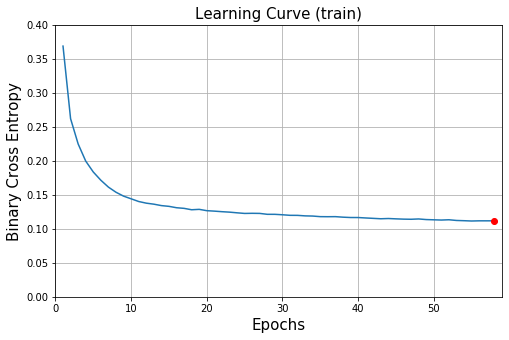

In [52]:
loss_train=loss_np[:best_epoch+3,0]
train_step=range(1,best_epoch+4)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (train)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+4)
    ax.set_ylim(0.0,0.4)
    return l

def gen_dot():
    for i in range(1,best_epoch+4):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figures/1120/loss-region3.gif', writer='imagemagick', fps=30)
plt.show()

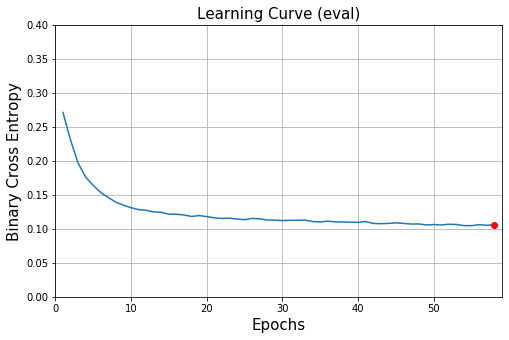

In [53]:
loss_train=loss_test_np[:best_epoch+3,0]
train_step=range(1,best_epoch+4)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (eval)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+4)
    ax.set_ylim(0.0,0.4)
    return l

def gen_dot():
    for i in range(1,best_epoch+4):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figures/1120/loss-region3-test.gif', writer='imagemagick', fps=30)
plt.show()

Free GPU memory:

In [54]:
del TrainLoader
torch.cuda.empty_cache()
del TrainDataset
torch.cuda.empty_cache()
#del dataTrainTensor
#torch.cuda.empty_cache()
del WeightTensor
torch.cuda.empty_cache()

Apply DNN model function:

In [55]:
def eval_pytorch(model,device,input_loader):
    output_numpy=[1]
    model.eval()
    with torch.no_grad():
        for batch_idx, (data1) in enumerate(input_loader):
            score=model(data1)
            del data1
            score_np=score.data.cpu().numpy()
            output_numpy=np.vstack((output_numpy,score_np))
            torch.cuda.empty_cache()
    return(output_numpy)

Test DNN model on signal and background dataset:

In [56]:
signalTensor = torch.tensor(signalSample1, dtype=torch.float, device=device)
signalLoader=DataLoader(signalTensor,batch_size=10000, shuffle=False)

sigScore = eval_pytorch(model,device,signalLoader)
sigScore=sigScore[1:,0]
print(sigScore)
print(len(sigScore))
plt.hist(sigScore,bins=20,weights=signalWeight)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
#plt.text(0.1, 2.5,'$\mathit{ATLAS}$', fontsize=15)
#plt.text(0.29, 2.5,'Internal', fontsize=12)
#plt.text(0.15,2.3,'$ 139 fb^{-1}$',fontsize=12)
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1120/NN-region3-sig.pdf', format='pdf', dpi=500)
plt.show()

[0.87741768 0.95178676 0.34731025 ... 0.64361817 0.40105507 0.99683398]
337216


[2.93837229e-06 6.62494415e-07 5.92684257e-04 ... 2.08244659e-03
 2.32708454e-02 3.43319577e-08]
2393786


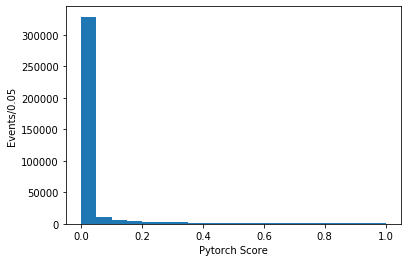

In [57]:
bakTensor= torch.tensor(backgroundSample1, dtype=torch.float,device=device)
backgroundLoader=DataLoader(bakTensor,batch_size=10000, shuffle=False)
bakScore = eval_pytorch(model,device,backgroundLoader)

bakScore=bakScore[1:,0]
print(bakScore)
print(len(bakScore))

plt.hist(bakScore,bins=20,weights=backgroundWeight)
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1120/NN-region3-bkg.pdf', format='pdf', dpi=500)
plt.show()

Create trainning and testing ROC curve:

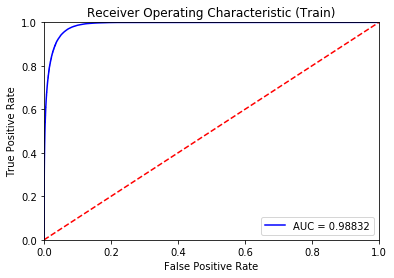

In [58]:
dataTrainTensor= torch.tensor(dataTrainSample1, dtype=torch.float,device=device)
dataTrainLoader=DataLoader(dataTrainTensor,batch_size=10000, shuffle=False)
TrainScore = eval_pytorch(model,device,dataTrainLoader)
TrainScore=TrainScore[1:,0]

fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,TrainScore,sample_weight=dataTrainWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Train)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1120/roc-region3-train-NN.pdf', format='pdf', dpi=500)
plt.show()

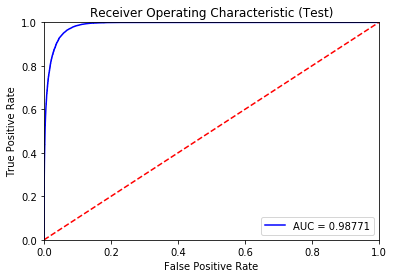

In [59]:
dataTestTensor= torch.tensor(dataTestSample1, dtype=torch.float,device=device)
dataTestLoader=DataLoader(dataTestTensor,batch_size=10000, shuffle=False)
TestScore = eval_pytorch(model,device,dataTestLoader)
TestScore=TestScore[1:,0]

fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,TestScore,sample_weight=dataTestWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Test)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1120/roc-region3-test-NN.pdf', format='pdf', dpi=500)
plt.show()

Save DNN model:

In [ ]:
torch.save(model.state_dict(),'../NN_model/region4-pytorch-1022.pt')

Cuda funciton used to calculate yields with different DNN cut:

In [60]:
reload(cuda_guass_normal)

<module 'cuda_guass_normal' from '/home/shuzhou/anaconda3/lib/python3.7/site-packages/cuda_guass_normal/__init__.py'>

Scan Limits and significance use different DNN cut:

In [ ]:
def cal_limit(bkg,sig):
    p=1.0
    num=int(bkg)+1
    mu=0
    while(p>0.05):
        p=poisson.cdf(num, bkg+mu*sig)
        mu=mu+0.01
    return(mu)

limit=np.zeros((20,1))
x=np.zeros((20,1))
sig=np.zeros((20,1))
k=0
for i in np.arange(0.8,1,0.01):
    resB=cuda_guass_normal.cuda_cut(bakScore,backgroundWeight,i)
    resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,i)
    x[k]=i
    limit[k]=cal_limit(resB,resS)
    sig[k]=resS/sqrt(resB)
    k=k+1

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))
plt.plot(x,limit)
plt.xlabel("DNN Cut")
plt.ylabel("95% CL Upper Limit")
plt.title("Upper Limits in HM/SF Region")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1022/Limits-Region3.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(8,6))
plt.plot(x,sig)
plt.xlabel("DNN Cut")
plt.ylabel("S/sqrt(B)")
plt.title("Significance in HM/SF Region")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1022/Sig-Region3.pdf', format='pdf', dpi=500)
plt.show()

In [61]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.1):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_guass_normal.cuda_cut(bakScore,backgroundWeight,BDT_cut)
            resS=cuda_guass_normal.cuda_cut(sigScore,signalWeight,BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut NN at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)

(0.8, 0.7, 0.6, 0.5, 0.4, 0.3)
If cut NN at  0.41100000000000003 signal yield is: [84803.85571298]  Eff is: [0.89980302]  background yield is: [13237.09922198]  Eff is:  [0.0354353]  S/B ratio is:  [6.40652867]  Significance is:  [737.08773779]
If cut NN at  0.642 signal yield is: [75381.38284719]  Eff is: [0.7998268]  background yield is: [6444.75025913]  Eff is:  [0.0172524]  S/B ratio is:  [11.69655608]  Significance is:  [938.99018743]
If cut NN at  0.785 signal yield is: [65955.2570094]  Eff is: [0.69981181]  background yield is: [3467.86331231]  Eff is:  [0.00928336]  S/B ratio is:  [19.01898981]  Significance is:  [1120.00105409]
If cut NN at  0.874 signal yield is: [56548.18700071]  Eff is: [0.59999901]  background yield is: [1879.19090832]  Eff is:  [0.00503054]  S/B ratio is:  [30.09177341]  Significance is:  [1304.46741231]
If cut NN at  0.927 signal yield is: [46960.39624162]  Eff is: [0.4982687]  background yield is: [1001.20430849]  Eff is:  [0.00268019]  S/B ratio is:  [

XGBoost part:

In [62]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet","m_hh"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample,feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample,feature_names=varName)
param = {'max_depth': 5, 'eta':0.05,'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
#if no GPU, use param['tree_methond']='hist'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
#param['subsample']=0.9
evallist = [(BDTtest, 'eval')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


In [64]:
num_round = 3000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=5)

[0]	eval-auc:0.842257
Will train until eval-auc hasn't improved in 5 rounds.
[1]	eval-auc:0.844357
[2]	eval-auc:0.851874
[3]	eval-auc:0.854152
[4]	eval-auc:0.85586
[5]	eval-auc:0.863569
[6]	eval-auc:0.86643
[7]	eval-auc:0.868793
[8]	eval-auc:0.872534
[9]	eval-auc:0.873713
[10]	eval-auc:0.875967
[11]	eval-auc:0.876954
[12]	eval-auc:0.877591
[13]	eval-auc:0.878469
[14]	eval-auc:0.879951
[15]	eval-auc:0.879884
[16]	eval-auc:0.880558
[17]	eval-auc:0.880895
[18]	eval-auc:0.882632
[19]	eval-auc:0.883035
[20]	eval-auc:0.88415
[21]	eval-auc:0.884228
[22]	eval-auc:0.884832
[23]	eval-auc:0.885465
[24]	eval-auc:0.886281
[25]	eval-auc:0.887139
[26]	eval-auc:0.887773
[27]	eval-auc:0.888093
[28]	eval-auc:0.888682
[29]	eval-auc:0.889248
[30]	eval-auc:0.890999
[31]	eval-auc:0.891687
[32]	eval-auc:0.892364
[33]	eval-auc:0.893172
[34]	eval-auc:0.894302
[35]	eval-auc:0.894632
[36]	eval-auc:0.896084
[37]	eval-auc:0.896773
[38]	eval-auc:0.897031
[39]	eval-auc:0.897605
[40]	eval-auc:0.898044
[41]	eval-auc:0

[346]	eval-auc:0.958441
[347]	eval-auc:0.958513
[348]	eval-auc:0.958565
[349]	eval-auc:0.958585
[350]	eval-auc:0.958591
[351]	eval-auc:0.95863
[352]	eval-auc:0.958633
[353]	eval-auc:0.958641
[354]	eval-auc:0.958663
[355]	eval-auc:0.958684
[356]	eval-auc:0.958689
[357]	eval-auc:0.958703
[358]	eval-auc:0.958706
[359]	eval-auc:0.958718
[360]	eval-auc:0.958728
[361]	eval-auc:0.958843
[362]	eval-auc:0.958954
[363]	eval-auc:0.958958
[364]	eval-auc:0.958956
[365]	eval-auc:0.958959
[366]	eval-auc:0.958971
[367]	eval-auc:0.958978
[368]	eval-auc:0.958982
[369]	eval-auc:0.958993
[370]	eval-auc:0.959003
[371]	eval-auc:0.95902
[372]	eval-auc:0.959024
[373]	eval-auc:0.95905
[374]	eval-auc:0.95905
[375]	eval-auc:0.959052
[376]	eval-auc:0.959058
[377]	eval-auc:0.959086
[378]	eval-auc:0.959227
[379]	eval-auc:0.959316
[380]	eval-auc:0.959319
[381]	eval-auc:0.959323
[382]	eval-auc:0.95934
[383]	eval-auc:0.959379
[384]	eval-auc:0.959397
[385]	eval-auc:0.95941
[386]	eval-auc:0.95946
[387]	eval-auc:0.959477

[689]	eval-auc:0.965355
[690]	eval-auc:0.965431
[691]	eval-auc:0.965449
[692]	eval-auc:0.965454
[693]	eval-auc:0.965482
[694]	eval-auc:0.965534
[695]	eval-auc:0.965537
[696]	eval-auc:0.965546
[697]	eval-auc:0.965572
[698]	eval-auc:0.965597
[699]	eval-auc:0.965629
[700]	eval-auc:0.965635
[701]	eval-auc:0.965637
[702]	eval-auc:0.965636
[703]	eval-auc:0.965663
[704]	eval-auc:0.965687
[705]	eval-auc:0.965692
[706]	eval-auc:0.965694
[707]	eval-auc:0.965705
[708]	eval-auc:0.965709
[709]	eval-auc:0.965713
[710]	eval-auc:0.96573
[711]	eval-auc:0.965752
[712]	eval-auc:0.965755
[713]	eval-auc:0.96576
[714]	eval-auc:0.965762
[715]	eval-auc:0.965765
[716]	eval-auc:0.965774
[717]	eval-auc:0.965772
[718]	eval-auc:0.965793
[719]	eval-auc:0.965801
[720]	eval-auc:0.965835
[721]	eval-auc:0.96584
[722]	eval-auc:0.965842
[723]	eval-auc:0.965849
[724]	eval-auc:0.965878
[725]	eval-auc:0.9659
[726]	eval-auc:0.96591
[727]	eval-auc:0.96591
[728]	eval-auc:0.965915
[729]	eval-auc:0.965941
[730]	eval-auc:0.965969

In [65]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)

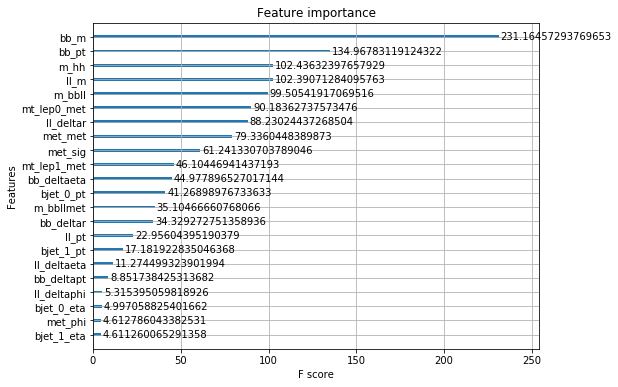

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))
xgb.plot_importance(GBDT,importance_type="gain",ax=ax)
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1120/ranking-region3-gain.pdf', format='pdf', dpi=500)

In [ ]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore,sample_weight=dataTrainWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1022/roc-region4-train-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore,sample_weight=dataTestWeight)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/1022/roc-region4-test-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_guass_normal.cuda_cut(SignalScore,signalWeight,i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_guass_normal.cuda_cut(BackgroundScore,backgroundWeight,BDT_cut)
            resS=cuda_guass_normal.cuda_cut(SignalScore,signalWeight,BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)